In [1]:
import torch
from transformers import AutoTokenizer
from transformers.models.llama import LlamaForCausalLM
from transformers.models.llama.modeling_llama import LlamaMLP
from torch.utils.data import DataLoader
from datasets import load_dataset
from TwoSpecHeadsModel import *

import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset


/home/jupyter/.local/lib/python3.10/site-packages/transformers/utils/hub.py:105: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(
2025-04-13 12:03:30.605943: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744545812.362017    9136 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744545812.920837    9136 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744545816.876895    9136 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744545816.876945    9136 comp

In [2]:
dtype = torch.bfloat16
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load tokenizer and base model
tokenizer = AutoTokenizer.from_pretrained("unsloth/Llama-3.2-1B-Instruct")
tokenizer.pad_token = tokenizer.eos_token

base_model = LlamaForCausalLM.from_pretrained("unsloth/Llama-3.2-1B-Instruct", torch_dtype=dtype)
base_model.to(device)
base_model.eval()


LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 2048, padding_idx=128004)
    (layers): ModuleList(
      (0-15): 16 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2048, out_features=512, bias=False)
          (v_proj): Linear(in_features=2048, out_features=512, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=2048, out_features=8192, bias=False)
          (up_proj): Linear(in_features=2048, out_features=8192, bias=False)
          (down_proj): Linear(in_features=8192, out_features=2048, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
      )
    )
    (norm): LlamaRMSNorm((2048,), eps=1e-0

In [3]:
speculator_head_one = PredictorHead(base_model.model.config)
speculator_head_one.load_state_dict(torch.load("../new_nn_decoder_head1.pth"))
speculator_head_one.to(device, dtype=dtype)

speculator_head_two = PredictorHead(base_model.model.config)
speculator_head_two.load_state_dict(torch.load("second_nn_decoder_head1.pth"))
speculator_head_two.to(device, dtype=dtype)

specModel = ThreeHeadModel(base_model, speculator_head_one, speculator_head_two)
specModel.to(device, dtype=dtype)
specModel.eval()

ThreeHeadModel(
  (base_model): LlamaForCausalLM(
    (model): LlamaModel(
      (embed_tokens): Embedding(128256, 2048, padding_idx=128004)
      (layers): ModuleList(
        (0-15): 16 x LlamaDecoderLayer(
          (self_attn): LlamaAttention(
            (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
            (k_proj): Linear(in_features=2048, out_features=512, bias=False)
            (v_proj): Linear(in_features=2048, out_features=512, bias=False)
            (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
          )
          (mlp): LlamaMLP(
            (gate_proj): Linear(in_features=2048, out_features=8192, bias=False)
            (up_proj): Linear(in_features=2048, out_features=8192, bias=False)
            (down_proj): Linear(in_features=8192, out_features=2048, bias=False)
            (act_fn): SiLU()
          )
          (input_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
          (post_attention_layernorm): LlamaRMSNorm((2048,),

In [4]:
class PrefixTuningModel(nn.Module):
    def __init__(self, base_model, speculator_head_one, speculator_head_two, prefix_length):
        """
        Args:
            base_model: The pre-trained LlamaForCausalLM model.
            speculator_head: The additional head (predicting the second token).
            prefix_length: Number of trainable prefix tokens.
        """
        super(PrefixTuningModel, self).__init__()
        self.base_model = base_model
        self.prefix_length = prefix_length
        self.hidden_size = base_model.config.hidden_size
        self.prefix_embeddings = nn.Parameter(torch.randn(prefix_length, self.hidden_size, dtype=dtype))
        self.main_head = base_model.lm_head
        self.speculator_head_one = speculator_head_one
        self.speculator_head_two = speculator_head_two

    def forward(self, input_ids, attention_mask=None):
        batch_size = input_ids.shape[0]
        input_embeds = self.base_model.model.embed_tokens(input_ids)  # shape: [batch, seq_len, hidden_size]
        prefix_embeds = self.prefix_embeddings.unsqueeze(0).expand(batch_size, -1, -1)
        concat_embeds = torch.cat([prefix_embeds, input_embeds], dim=1)
        
        if attention_mask is not None:
            prefix_mask = torch.ones(batch_size, self.prefix_length, device=attention_mask.device)
            attention_mask = torch.cat([prefix_mask, attention_mask], dim=1)
            
        outputs = self.base_model.model(inputs_embeds=concat_embeds, attention_mask=attention_mask)
        hidden_states = outputs.last_hidden_state  # shape: [batch, (prefix+seq_len), hidden_size]
        
        logits_main = self.main_head(hidden_states)
        batch_size, seq_len, _ = hidden_states.shape
        
        logits_speculator_one = self.speculator_head_one(hidden_states)
        logits_speculator_two = self.speculator_head_two(hidden_states)
        return logits_main, logits_speculator_one, logits_speculator_two

In [5]:
from torch.optim.lr_scheduler import LinearLR

prefix_length = 8

p_tuning_model = PrefixTuningModel(base_model, speculator_head_one, speculator_head_two, prefix_length)

p_tuning_model.to(device)

for param in p_tuning_model.base_model.parameters():
    param.requires_grad = False
for param in p_tuning_model.speculator_head_one.parameters():
    param.requires_grad = False
for param in p_tuning_model.speculator_head_two.parameters():
    param.requires_grad = False

torch.manual_seed(11786353908476520374)
optimizer = optim.Adam(p_tuning_model.parameters(), lr=1e-3)

torch.manual_seed(11786353908476520374)
criterion = nn.CrossEntropyLoss()
torch.manual_seed(11786353908476520374)


dataset = load_dataset("gsm8k", "main")

tokenizer = AutoTokenizer.from_pretrained("unsloth/Llama-3.2-1B-Instruct")
tokenizer.pad_token = tokenizer.eos_token

def collate_fn(batch):
    input_ids = [example["input_ids"] for example in batch]
    padded = tokenizer.pad({"input_ids": input_ids}, return_tensors="pt")
    return padded

In [6]:
# dataset = dataset.select(range(8000))

print(len(dataset))


2


In [7]:
MAX_LENGTH = 128  # Max tokens per sequence
BATCH_SIZE = 8

class MathDataset(Dataset):
    def __init__(self, split="train"):
        self.data = dataset[split]
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        item = self.data[idx]
        question = item["question"]
        answer = item["answer"]

        # Tokenize input and label
        encoding = tokenizer(question, padding="max_length", truncation=True, max_length=MAX_LENGTH, return_tensors="pt")
        label_encoding = tokenizer(answer, padding="max_length", truncation=True, max_length=MAX_LENGTH, return_tensors="pt")

        input_ids = encoding["input_ids"].squeeze(0)  # Remove batch dim
        attention_mask = encoding["attention_mask"].squeeze(0)
        labels = label_encoding["input_ids"].squeeze(0)  # Labels are the tokenized answer

        return {"input_ids": input_ids, "attention_mask": attention_mask, "labels": labels}

train_dataset = MathDataset("train")
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

val_dataset = MathDataset("test")
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)


In [8]:
# trainable params count:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print("Trainable parameters:", count_parameters(p_tuning_model))

Trainable parameters: 16384


In [9]:
import tqdm

batch = next(iter(tqdm.tqdm(train_dataloader)))

print(f"indput_ids: {batch['input_ids'].size()}")
print(f"labels: {batch['labels'].size()}")
print(f"attention_mask: {batch['attention_mask'].size()}")

input_ids = batch['input_ids'].to(device)
labels = batch['labels'].to(device)
attention_mask = batch['attention_mask'].to(device)

specModel.eval()

model_logits_main, model_logits_speculator_one, model_logits_speculator_two = specModel(input_ids, attention_mask)

print(f'main_logits: {model_logits_main.size()}')
print(f'spec_logits_one: {model_logits_speculator_one.size()}')
print(f'spec_logits_two: {model_logits_speculator_two.size()}')


seq_length = input_ids.shape[1]
model_logits_main = model_logits_main[:, -seq_length:, :]
model_logits_speculator_one = model_logits_speculator_one[:, -seq_length:-1, :]


print(f'seq_length: {seq_length}')
print(f'new_logits_main: {model_logits_main.size()}')
print(f'new_logits_spec_one: {model_logits_speculator_one.size()}')

print('first_loss: ')
print(f'{model_logits_main.contiguous().view(-1, model_logits_main.size(-1)).size()}')
print(f'{labels.view(-1).size()}')
      
print('second_loss: ')
print(f'{model_logits_speculator_one.contiguous().view(-1, model_logits_speculator_one.size(-1)).size()}')
print(f'{labels[:, 1:].reshape(-1).size()}')

model_loss_main = criterion(
    model_logits_main.contiguous().view(-1, model_logits_main.size(-1)),
    labels.view(-1)
)
model_loss_head = criterion(
    model_logits_speculator_one.contiguous().view(-1, model_logits_speculator_one.size(-1)),
    labels[:, 1:].reshape(-1)
)

  0%|          | 0/935 [00:00<?, ?it/s]

indput_ids: torch.Size([8, 128])
labels: torch.Size([8, 128])
attention_mask: torch.Size([8, 128])


main_logits: torch.Size([8, 128, 128256])
spec_logits_one: torch.Size([8, 128, 128256])
spec_logits_two: torch.Size([8, 128, 128256])
seq_length: 128
new_logits_main: torch.Size([8, 128, 128256])
new_logits_spec_one: torch.Size([8, 127, 128256])
first_loss: 
torch.Size([1024, 128256])
torch.Size([1024])
second_loss: 
torch.Size([1016, 128256])
torch.Size([1016])


In [10]:
print(batch['input_ids'])


tensor([[128009, 128009, 128009,  ...,    304,   2860,     30],
        [128009, 128009, 128009,  ...,    311,   2015,     30],
        [128009, 128009, 128009,  ...,    304,   2860,     30],
        ...,
        [128009, 128009, 128009,  ...,   1077,   1934,     30],
        [128009, 128009, 128009,  ...,  11999,   7437,     30],
        [128009, 128009, 128009,  ...,    311,   1304,     30]])


In [15]:
from IPython.display import clear_output
import warnings
import time
from datetime import timedelta
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
import torch

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def learning_loop(
    model,
    optimizer,
    train_dataloader,
    val_dataloader,
    criterion,
    scheduler=None,
    min_lr=None,
    epochs=3,
    val_every=100,
    draw_every=50,
    separate_show=False,
    model_name=None,
    chkp_folder="./chkps",
    metric_names=None,
):

    device = next(model.parameters()).device
    dtype = next(model.parameters()).dtype

    losses = {'train': [], 'val': [], 'accuracy_val': [], 'lr': []}
    # lrs = []
    best_val_loss = np.Inf
    if metric_names is not None:
        metrics = defaultdict(list)
    start_time = time.monotonic()
    
    # [1, 1, 0, 0, 0, 1, 1, 0, 0, 0]
    idx = 0

    for epoch in range(1, epochs + 1):
        model.train()

        for batch_idx, batch in enumerate(train_dataloader):
            if idx % 10 == 0:
                print(idx)
            idx += 1

            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            attention_mask = attention_mask.to(dtype=dtype)

            optimizer.zero_grad()

            model_logits_main, model_logits_speculator_one, model_logits_speculator_two = model(input_ids, attention_mask)

            seq_length = input_ids.shape[1]
            model_logits_main = model_logits_main[:, -seq_length:, :]
            model_logits_speculator_one = model_logits_speculator_one[:, -seq_length:-1, :]
            model_logits_speculator_two = model_logits_speculator_two[:, -seq_length:-2, :]

            model_loss_main = criterion(
                model_logits_main.contiguous().view(-1, model_logits_main.size(-1)),
                labels.view(-1)
            )
            model_loss_head_one = criterion(
                model_logits_speculator_one.contiguous().view(-1, model_logits_speculator_one.size(-1)),
                labels[:, 1:].reshape(-1)
            )
            model_loss_head_two = criterion(
                model_logits_speculator_two.contiguous().view(-1, model_logits_speculator_two.size(-1)),
                labels[:, 2:].reshape(-1)
            )

            if ((idx // 300) % 3 == 0):
                model_loss = model_loss_head_two
            elif ((idx // 300) % 3 == 1):
                model_loss = model_loss_head_one
            else:
                model_loss = model_loss_main
            
            model_loss.backward()
            
            optimizer.step()
            scheduler.step()

            
            current_lr = optimizer.param_groups[0]['lr']
            losses['lr'].append(current_lr)

            losses['train'].append(model_loss_main.item())

            # validation
            if idx % val_every == 0:
                model.eval()

                avg_loss_val = 0.0
                
                agree = 0
                total = 0

                with torch.no_grad():
                    for idx_val, batch in enumerate(val_dataloader):
                        if idx_val == 10:
                            break

                        input_ids = batch["input_ids"].to(device)
                        attention_mask = batch["attention_mask"].to(device)
                        labels = batch["labels"].to(device)

                        attention_mask = attention_mask.to(dtype=dtype)

                        model_logits_main_val, _, _ = model(input_ids, attention_mask)

                        seq_length = input_ids.shape[1]
                        model_logits_main_val = model_logits_main_val[:, -seq_length:, :]

                        val_loss = criterion(
                            model_logits_main_val.contiguous().view(-1, model_logits_main_val.size(-1)),
                            labels.view(-1)
                        ).item()
                        
                        avg_loss_val += val_loss
                        
                        #accuracy computation
                        preds = torch.argmax(model_logits_main_val, dim=-1)
                        
                        agree += (preds == labels).sum().item()
                        total += preds.numel()
                        

                avg_loss_val /= 10

                losses['val'].append(avg_loss_val)
                
                losses['accuracy_val'].append(agree / total if total > 0 else 0)

                torch.cuda.empty_cache()

                model.train()

            # plotting
            if idx % draw_every == 0:
                clear_output(True)
                plt.clf()
                plt.figure(figsize=(10, 5))

                plt.subplot(2, 2, 1)
                plt.plot(losses['train'], label='train_loss')
                plt.xlabel('Iter')
                plt.ylabel('Loss')
                plt.title('Training Losses')
                plt.legend()
                plt.grid(True)

                plt.subplot(2, 2, 2)
                plt.plot(losses['val'], label='val_loss')
                plt.xlabel('Iter')
                plt.ylabel('Loss')
                plt.title('Validation Losses')
                plt.legend()
                plt.grid(True)

                
                plt.subplot(2, 2, 3)
                plt.plot(losses['accuracy_val'], label='accuracy_val')
                plt.xlabel('Iter')
                plt.ylabel('accuracy')
                plt.title('Validation accuracy')
                plt.legend()
                plt.grid(True)          
                
                plt.subplot(2, 2, 4)
                plt.plot(losses['lr'], label='lr')
                plt.xlabel('Iter')
                plt.ylabel('lr')
                plt.title('learning_rate')
                plt.legend()
                plt.grid(True)

                plt.tight_layout()
                plt.show()

    return losses


In [16]:
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.optim.lr_scheduler import LinearLR


num_epochs = 4

total_steps = num_epochs * len(train_dataloader)  # Total training steps

scheduler = CosineAnnealingLR(optimizer, T_max=total_steps, eta_min=0)


In [17]:
print(total_steps)

3740


<Figure size 640x480 with 0 Axes>

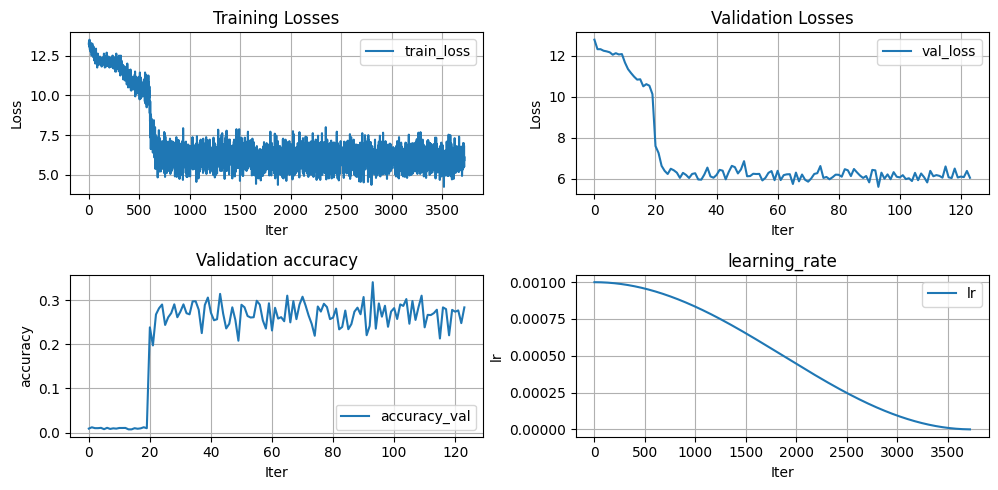

3720
3730


In [18]:
# from torch.optim.lr_scheduler import LinearLR  # Corrected import
import numpy as np

losses = learning_loop(
    p_tuning_model,
    optimizer,
    train_dataloader,
    val_dataloader,
    nn.CrossEntropyLoss(),
    scheduler=scheduler,
    min_lr=None,
    epochs=num_epochs,
    val_every=30,
    draw_every=40,
    separate_show=False,
    model_name=None,
    chkp_folder="./chkps",
    metric_names=None,
)



In [19]:
print(losses['train'])

[13.25, 13.3125, 13.375, 13.3125, 13.0625, 13.25, 13.3125, 13.5, 13.125, 13.0625, 12.9375, 12.875, 13.125, 13.125, 13.3125, 13.1875, 13.3125, 12.75, 13.0, 12.8125, 12.875, 12.8125, 12.875, 12.8125, 12.9375, 13.125, 12.75, 12.6875, 12.5, 12.9375, 13.0, 12.6875, 12.75, 12.9375, 12.75, 13.25, 12.625, 12.6875, 12.9375, 12.875, 12.625, 12.875, 12.625, 12.4375, 12.6875, 12.5625, 12.6875, 13.0625, 13.0, 12.375, 12.75, 12.5, 12.5, 12.875, 12.4375, 12.1875, 12.4375, 12.6875, 12.625, 12.25, 12.25, 12.75, 12.375, 12.125, 12.0, 12.3125, 12.375, 12.3125, 12.375, 12.125, 12.125, 12.9375, 12.4375, 12.4375, 12.375, 12.375, 12.5625, 12.3125, 12.4375, 12.0, 12.3125, 12.5, 11.9375, 11.75, 12.3125, 12.3125, 12.125, 12.1875, 12.125, 12.625, 12.4375, 12.25, 11.9375, 12.3125, 12.1875, 12.1875, 12.3125, 12.375, 12.375, 12.25, 12.0, 12.125, 12.0625, 12.0625, 12.25, 11.9375, 12.1875, 12.125, 12.0625, 12.3125, 12.4375, 12.25, 12.0, 12.0, 12.0625, 12.0, 12.375, 12.1875, 12.125, 12.1875, 12.0, 11.9375, 12.0, 12.06

In [20]:
print(losses['val'])

[12.775, 12.3125, 12.3125, 12.2375, 12.20625, 12.1625, 12.04375, 12.11875, 12.05625, 12.075, 11.6625, 11.34375, 11.15, 10.975, 10.83125, 10.85, 10.50625, 10.6125, 10.5375, 10.125, 7.6, 7.265625, 6.6375, 6.39375, 6.240625, 6.496875, 6.421875, 6.30625, 6.053125, 6.296875, 6.196875, 6.046875, 6.24375, 6.278125, 5.975, 5.965625, 6.215625, 6.553125, 6.125, 6.059375, 6.19375, 6.44375, 6.403125, 5.98125, 6.34375, 6.6375, 6.575, 6.26875, 6.465625, 6.865625, 6.13125, 6.140625, 6.253125, 6.240625, 6.246875, 5.928125, 6.053125, 6.296875, 6.384375, 5.940625, 6.396875, 5.946875, 6.1875, 6.225, 6.23125, 5.75625, 6.309375, 5.884375, 6.215625, 5.959375, 5.86875, 6.025, 6.24375, 6.28125, 6.628125, 6.05, 6.096875, 5.984375, 6.084375, 6.209375, 6.203125, 6.109375, 6.475, 6.421875, 6.140625, 6.484375, 6.31875, 6.165625, 6.05, 6.14375, 5.834375, 6.440625, 6.41875, 5.615625, 6.30625, 6.0125, 6.221875, 5.9875, 6.33125, 6.109375, 6.075, 6.184375, 5.99375, 6.034375, 5.9, 6.296875, 5.940625, 6.265625, 6.08125, 

In [21]:
print(losses['accuracy_val'])

[0.0091796875, 0.012109375, 0.01015625, 0.01015625, 0.01083984375, 0.0078125, 0.0109375, 0.0083984375, 0.009765625, 0.00908203125, 0.010546875, 0.010546875, 0.01064453125, 0.007421875, 0.007421875, 0.01005859375, 0.0087890625, 0.009765625, 0.01220703125, 0.0099609375, 0.23828125, 0.1974609375, 0.26748046875, 0.2814453125, 0.2900390625, 0.24375, 0.26103515625, 0.27060546875, 0.2904296875, 0.26123046875, 0.27392578125, 0.29033203125, 0.2703125, 0.2677734375, 0.2970703125, 0.29736328125, 0.27822265625, 0.22529296875, 0.28876953125, 0.30576171875, 0.2712890625, 0.25439453125, 0.256640625, 0.3140625, 0.26943359375, 0.23583984375, 0.2462890625, 0.28369140625, 0.255078125, 0.20810546875, 0.289453125, 0.28369140625, 0.26396484375, 0.260546875, 0.26123046875, 0.29853515625, 0.28984375, 0.25400390625, 0.235546875, 0.2927734375, 0.23125, 0.2826171875, 0.258203125, 0.261328125, 0.2521484375, 0.31005859375, 0.249609375, 0.29765625, 0.2568359375, 0.28974609375, 0.3076171875, 0.2876953125, 0.26494140

In [22]:
print(losses['lr'])

[0.0009998410727726586, 0.0009998405436592995, 0.0009998396618041163, 0.0009998384272077306, 0.0009998368398710141, 0.0009998348997950865, 0.0009998326069813167, 0.0009998299614313226, 0.0009998269631469707, 0.000999823612130377, 0.0009998199083839053, 0.0009998158519101696, 0.0009998114427120317, 0.000999806680792603, 0.0009998015661552434, 0.0009997960988035617, 0.0009997902787414158, 0.0009997841059729122, 0.0009997775805024064, 0.0009997707023345027, 0.0009997634714740545, 0.0009997558879261638, 0.0009997479516961813, 0.0009997396627897072, 0.0009997310212125896, 0.0009997220269709263, 0.0009997126800710635, 0.0009997029805195964, 0.0009996929283233689, 0.0009996825234894738, 0.000999671766025253, 0.0009996606559382966, 0.0009996491932364438, 0.0009996373779277829, 0.0009996252100206505, 0.0009996126895236324, 0.0009995998164455632, 0.0009995865907955256, 0.000999573012582852, 0.000999559081817123, 0.0009995447985081682, 0.0009995301626660657, 0.0009995151743011426, 0.0009994998334